<a href="https://colab.research.google.com/github/MDfarazuddin99/CNN_Pruning/blob/master/HISTORICAL_CORRELATION_OF_L1_NORMSs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model

Using TensorFlow backend.


In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test
from keras.utils import np_utils
x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

Instructions for updating:
non-resource variables are not supported in the long term






In [0]:
my_model = model_1
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [0]:
my_model = load_model('drive/My Drive/Colab Notebooks/model1_before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1] * 100)

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1] * 100)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50000/50000 [==============================] - 10s 203us/step
Accuracy on the Train Images:  89.974
10000/10000 [==============================] - 1s 77us/step
Accuracy on the Test Images:  67.93


In [0]:
def my_get_all_conv_layers(model , first_time):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)
    return all_conv_layers if (first_time==True) else all_conv_layers[1:]


def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model,True)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


All convolution layers =  [0, 2, 4] 
All dense layers =  [7]


In [0]:

layer_wise_weights_for_all_epochs = list()

def my_get_weights_in_conv_layers(model,first_time):
 
  weights = list()
  all_conv_layers = my_get_all_conv_layers(model,first_time)
  layer_wise_weights = list() 
  for i in all_conv_layers:
        weights.append(model.layers[i].get_weights()[0])  
  return weights




In [0]:
x = (my_get_weights_in_conv_layers(my_model,True))
print('shapes of weight Tensors in convolutional layers are')
for i in x:
    print(i.shape)

shapes of weight Tensors in convolutional layers are
(3, 3, 3, 32)
(3, 3, 32, 32)
(3, 3, 32, 64)


In [0]:
my_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_model.fit(x_train, y_train, batch_size=32, epochs=2, verbose=1, validation_split=0.2, shuffle=True  )

Train on 40000 samples, validate on 10000 samples
Epoch 1/2
40000/40000 [==============================] - 10s 252us/step - loss: 0.1510 - acc: 0.9471 - val_loss: 2.6093 - val_acc: 0.6705
Epoch 2/2
40000/40000 [==============================] - 10s 241us/step - loss: 0.1391 - acc: 0.9504 - val_loss: 2.6004 - val_acc: 0.6809


In [0]:
from keras.callbacks import Callback

class Get_Weights(Callback):
    def __init__(self,first_time):
        super(Get_Weights, self).__init__()
        self.weight_list = [] #Using a list of list to store weight tensors per epoch
        self.first_time = first_time
    def on_epoch_end(self,epoch,logs=None):
        if epoch == 0:
            all_conv_layers = my_get_all_conv_layers(self.model,self.first_time)
            for i in range(len(all_conv_layers)):
                self.weight_list.append([]) # appending empty lists for later appending weight tensors 
        
        for index,each_weight in enumerate(my_get_weights_in_conv_layers(self.model,self.first_time)):
                self.weight_list[index].append(each_weight)  
    



In [0]:
gw = Get_Weights(True)

my_model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2, shuffle=True , callbacks= [gw] )


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 10s 242us/step - loss: 0.1324 - acc: 0.9537 - val_loss: 2.7064 - val_acc: 0.6715
Epoch 2/5
40000/40000 [==============================] - 10s 244us/step - loss: 0.1285 - acc: 0.9546 - val_loss: 2.6750 - val_acc: 0.6778
Epoch 3/5
40000/40000 [==============================] - 10s 240us/step - loss: 0.1380 - acc: 0.9519 - val_loss: 2.7330 - val_acc: 0.6695
Epoch 4/5
40000/40000 [==============================] - 10s 239us/step - loss: 0.1320 - acc: 0.9527 - val_loss: 2.7245 - val_acc: 0.6718
Epoch 5/5
40000/40000 [==============================] - 10s 242us/step - loss: 0.1288 - acc: 0.9531 - val_loss: 2.7039 - val_acc: 0.6769


In [0]:
for we in gw.weight_list:
    print(np.array(we).shape)
weight_list_per_epoch = gw.weight_list

(5, 3, 3, 3, 32)
(5, 3, 3, 32, 32)
(5, 3, 3, 32, 64)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

shapes of a b c are  (5, 27, 32) (5, 288, 32) (5, 288, 64)
(32, 5)


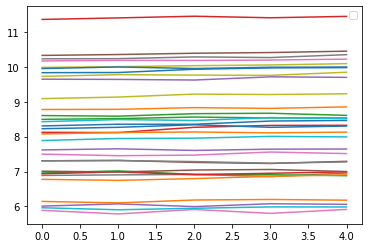

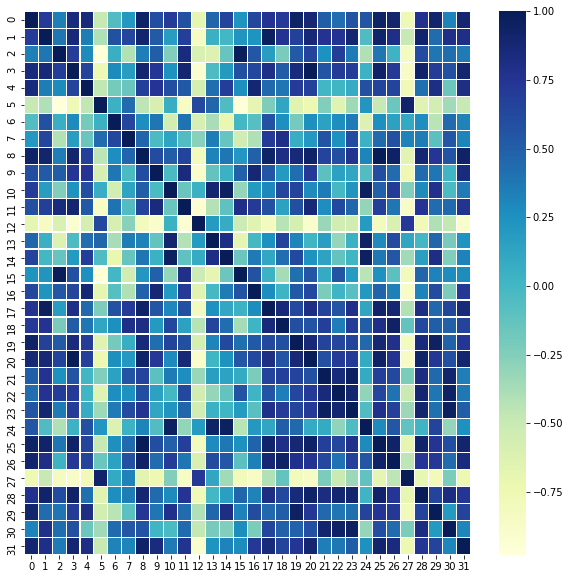

In [0]:

a = np.array(weight_list_per_epoch[0]).reshape(5,3*3*3,-1)
b = np.array(weight_list_per_epoch[1]).reshape(5,3*3*32,-1)
c = np.array(weight_list_per_epoch[2]).reshape(5,3*3*32,-1)
print("shapes of a b c are ",a.shape,b.shape,c.shape)
a,b,c = abs(a),abs(b),abs(c)

x1 = np.sum(a,axis = 1)

x1 = x1.T
print(x1.shape)



for i in range(x1.shape[0]):
    plt.plot(np.arange(5),x1[i])
    plt.legend()
# plt.plot(np.arange(10),x1[1])
# plt.plot(np.arange(10),x1[2])
# plt.plot(np.arange(10),x1[3])


import pandas as pd
import seaborn as sns
df = pd.DataFrame(x1.T)
corrmat = df.corr(method='pearson')
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)


#  the above variable (weight_list_per_epoch) should be stord in some csv/h5 file.

In [0]:
print(np.array(weight_list_per_epoch[0]).shape)
print(np.array(weight_list_per_epoch[1]).shape)
print(np.array(weight_list_per_epoch[2]).shape)

def my_get_l1_norms_filters_per_epoch(weight_list_per_epoch):
    l1_norms_filters_per_epoch = list()
    

    for index in range(len(weight_list_per_epoch)):

        epochs = np.array(weight_list_per_epoch[index]).shape[0]
        h , w , d = np.array(weight_list_per_epoch[index]).shape[1], np.array(weight_list_per_epoch[index]).shape[2] , np.array(weight_list_per_epoch[index]).shape[3]


        l1_norms_filters_per_epoch.append(np.sum(np.array(weight_list_per_epoch[index]).reshape(epochs,h*w*d,-1),axis=1))
    return l1_norms_filters_per_epoch

(5, 3, 3, 3, 32)
(5, 3, 3, 32, 32)
(5, 3, 3, 32, 64)


In [0]:
A = my_get_l1_norms_filters_per_epoch(weight_list_per_epoch)
for i in A:
    print(i.shape) 

(5, 32)
(5, 32)
(5, 64)


In [0]:
# print(corrmat)()
layer_wise_correlations = list()
layer_wise_correlations.append(corrmat)

In [0]:
# def get_layer_wise_correlations(weight_list_per_epoch):
#   layer_wise_correlations = list()

In [0]:
layer_wise_correlations = list()
layer_wise_correlations.append(corrmat)

x2 = np.sum(b,axis = 1)
print(x2.shape)
df = pd.DataFrame(x2)
corrmat = df.corr(method='pearson')

# nan_array = np.isnan(corrmat)

# not_nan_array = ~ nan_array

# corrmat = corrmat[not_nan_array]



layer_wise_correlations.append(corrmat)

x3 = np.sum(c,axis = 1)
print(x3.shape)
df = pd.DataFrame(x3)
corrmat = df.corr(method='pearson')
layer_wise_correlations.append(corrmat)
# # print(corrmat)
# # corrmat = np.array(corrmat)
# # nan_array = np.isnan(corrmat)

# # not_nan_array = ~ nan_array

# # corrmat = corrmat[not_nan_array]
# import math
# # corrmat = [x for x in corrmat if  str(x) != 'NaN']
# corrmat = np.array(corrmat)
# # corrmat = [x for x in corrmat if ~np.isnan(x)]
# corrmat = corrmat[~np.isnan(corrmat)]
# print(corrmat.shape)
# layer_wise_correlations.append(corrmat)

# # print(df)

(5, 32)
(5, 64)


In [0]:
\
# x2 = np.sum(a,axis = 1)
# df = pd.DataFrame(x2.T)
# corrmat__2 = df.corr(method='pearson')

In [0]:
np.array(layer_wise_correlations).shape

(3,)

In [0]:
# print(np.array(corrmat__2).shape)

In [0]:
# print(np.array(layer_wise_correlations).shape)

In [0]:
print(np.array(corrmat).shape)

(64, 64)


In [0]:

def get_nan_indexes(data_frame):
    indexes = []
    print(data_frame)
    for column in data_frame:
        index = data_frame[column].index[data_frame[column].apply(np.isnan)]
        if len(index):
            indexes.append(index[0])
    df_index = data_frame.index.values.tolist()
    return [df_index.index(i) for i in set(indexes)]

df  = pd.DataFrame(corrmat)
# x = get_nan_indexes(df)
x = df.notna()
print(x)
df.idxmax()

      0     1     2     3     4     5   ...     58    59    60    61    62    63
0   True  True  True  True  True  True  ...  False  True  True  True  True  True
1   True  True  True  True  True  True  ...  False  True  True  True  True  True
2   True  True  True  True  True  True  ...  False  True  True  True  True  True
3   True  True  True  True  True  True  ...  False  True  True  True  True  True
4   True  True  True  True  True  True  ...  False  True  True  True  True  True
..   ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   ...
59  True  True  True  True  True  True  ...  False  True  True  True  True  True
60  True  True  True  True  True  True  ...  False  True  True  True  True  True
61  True  True  True  True  True  True  ...  False  True  True  True  True  True
62  True  True  True  True  True  True  ...  False  True  True  True  True  True
63  True  True  True  True  True  True  ...  False  True  True  True  True  True

[64 rows x 64 columns]


0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
      ... 
59    59.0
60    60.0
61    61.0
62    62.0
63    63.0
Length: 64, dtype: float64

In [0]:

# def get_pruning_indices(layer_wise_correlations , epoch_number):
def get_pruning_indices(layer_wise_correlations , threshold):
    layer_wise_pruning_indices = list()
    for i in range(len(layer_wise_correlations)):
      this_layer_pruning_indices = list()
      corrmat = layer_wise_correlations[i]
      corrmat = corrmat[(corrmat != 1.0) & (corrmat > threshold)] # threshold 0.9
      # print(corrmat)
      df = pd.DataFrame(corrmat)
      correlation_pairs =  np.where(np.asanyarray(~np.isnan(df)))

      # to remove any of then randomly 
      layer_wise_pruning_indices.append(list(dict.fromkeys(correlation_pairs[0])))

      # to remove based on the highest L1 norm
    #   for j in range(len(correlation_pairs[0])):
    #     # check this
    #     if A[i][epoch_number][correlation_pairs[0][j]] > A[i][epoch_number][correlation_pairs[1][j]]:
    #       this_layer_pruning_indices.append(correlation_pairs[0][j])
    #     else:
    #       this_layer_pruning_indices.append(correlation_pairs[1][j])
    #   layer_wise_pruning_indices.append(this_layer_pruning_indices)
    return layer_wise_pruning_indices
# print(layer_wise_correlations)


In [0]:
x = get_pruning_indices(layer_wise_correlations , 0.9)

for i in range(3):
  print(x[i])
  print(np.array(x[i]).shape)

In [0]:
x = get_pruning_indices(layer_wise_correlations, 0.95)


for i in range(3):
  print(x[i])
  print(np.array(x[i]).shape)

In [0]:
x = get_pruning_indices(layer_wise_correlations, 0.96)

for i in range(3):
  print(x[i])
  print(np.array(x[i]).shape)

In [0]:

x = get_pruning_indices(layer_wise_correlations, 0.98)

for i in range(3):
  print(x[i])
  print(np.array(x[i]).shape)

In [0]:
!pip install kerassurgeon
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [0]:
def my_delete_filters(model):
    conv_layer_indices = my_get_all_conv_layers(model)
    pruning_indices_of_all_layers = get_pruning_indices(layer_wise_correlations , 0.96)
    surgeon = Surgeon(model)
    for index , value in enumerate(conv_layer_indices):
      print(value , index , pruning_indices_of_all_layers [index] )
      surgeon.add_job('delete_channels' , model.layers[value] , channels = pruning_indices_of_all_layers[index] )
    
    model_new = surgeon.operate()
    return model_new

In [0]:
m = my_delete_filters(my_model)

In [0]:
m.summary()

In [0]:
model_new = m
model_new.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


In [0]:
model_new.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.2, shuffle=True)


In [0]:

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


In [0]:
model  = model_new 


validation_accuracy = model.evaluate(x_test,y_test)[1]
print(validation_accuracy)
max_val_acc = validation_accuracy

while abs(max_val_acc - validation_accuracy)<= 0.05 :
  
    if max_val_acc < validation_accuracy:
        max_val_acc = validation_accuracy


    conv_layer_indices = my_get_all_conv_layers(model)
    pruning_indices_of_all_layers = get_pruning_indices(layer_wise_correlations , 0.96)
    surgeon = Surgeon(model)
    for index , value in enumerate(conv_layer_indices):
      print(value , index , pruning_indices_of_all_layers [index] )
      surgeon.add_job('delete_channels' , model.layers[value] , channels = pruning_indices_of_all_layers[index] )
    
    model_new = surgeon.operate()


    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
    validation_accuracy = model.evaluate(x_test,y_test)[1]
    print("--->",validation_accuracy)